In [1]:
from collections import namedtuple
from functools import lru_cache

_Node = namedtuple("Node", ["k", "a", "b", "c", "d", "n", "hash"])

class Node(_Node):    
     def __hash__(self):
        return self.hash
    
     def __repr__(self):
        return f"Node k={self.k}, {1<<self.k} x {1<<self.k}, population {self.n}"
               
# base level binary nodes
on = Node(0, None, None, None, None, 1, 1)
off = Node(0, None, None, None, None, 0, 0)

In [9]:
@lru_cache(maxsize=2**24)
def join(a, b, c, d):        
    n = a.n + b.n + c.n + d.n
    nhash = (
            a.k + 2 +
            + 5131830419411 * a.hash
            + 3758991985019 * b.hash
            + 8973110871315 * c.hash
            + 4318490180473 * d.hash
        ) & ((1 << 63) - 1)    
    return Node(a.k + 1, a, b, c, d, n, nhash)    

In [10]:
@lru_cache(maxsize=1024)
def get_zero(k):
    return off if k==0 else join(get_zero(k - 1), get_zero(k - 1), get_zero(k - 1), get_zero(k - 1))

def centre(m):
    z = get_zero(m.k - 1)  # get the right-sized zero node
    return join(
        join(z, z, z, m.a), join(z, z, m.b, z), join(z, m.c, z, z), join(m.d, z, z, z)
    )


In [11]:
# life rule, for a 3x3 collection of cells, where E is the centre
def life(a, b, c, d, E, f, g, h, i):
    outer = sum([t.n for t in [a, b, c, d, f, g, h, i]])
    return on if (E.n and outer == 2) or outer == 3 else off

def life_4x4(m):
    na = life(m.a.a, m.a.b, m.b.a, m.a.c, m.a.d, m.b.c, m.c.a, m.c.b, m.d.a)  # AD
    nb = life(m.a.b, m.b.a, m.b.b, m.a.d, m.b.c, m.b.d, m.c.b, m.d.a, m.d.b)  # BC    
    nc = life(m.a.c, m.a.d, m.b.c, m.c.a, m.c.b, m.d.a, m.c.c, m.c.d, m.d.c)  # CB
    nd = life(m.a.d, m.b.c, m.b.d, m.c.b, m.d.a, m.d.b, m.c.d, m.d.c, m.d.d)  # DA
    return join(na, nb, nc, nd)

In [38]:
@lru_cache(maxsize=2**24)
def successor(m, j=None):
    """Return the 2**k-1 x 2**k-1 successor, 2**j generations in the future"""        
    if m.n==0: # empty
        return m.a    
    elif m.k == 2:  # base case               
        s = life_4x4(m)    
    else:        
        c1 = successor(join(m.a.a, m.a.b, m.a.c, m.a.d), j)
        c2 = successor(join(m.a.b, m.b.a, m.a.d, m.b.c), j)
        c3 = successor(join(m.b.a, m.b.b, m.b.c, m.b.d), j)
        c4 = successor(join(m.a.c, m.a.d, m.c.a, m.c.b), j)        
        c5 = successor(join(m.a.d, m.b.c, m.c.b, m.d.a), j)
        c6 = successor(join(m.b.c, m.b.d, m.d.a, m.d.b), j)
        c7 = successor(join(m.c.a, m.c.b, m.c.c, m.c.d), j)
        c8 = successor(join(m.c.b, m.d.a, m.c.d, m.d.c), j)
        c9 = successor(join(m.d.a, m.d.b, m.d.c, m.d.d), j)
        
        if j is not None and j < m.k - 2:
            return join(
                (join(c1.d, c2.c, c4.b, c5.a)),
                (join(c2.d, c3.c, c5.b, c6.a)),
                (join(c4.d, c5.c, c7.b, c8.a)),
                (join(c5.d, c6.c, c8.b, c9.a)),
            )    
        else:
            return join(
            successor(join(c1, c2, c4, c5), j),
            successor(join(c2, c3, c5, c6), j),
            successor(join(c4, c5, c7, c8), j),
            successor(join(c5, c6, c8, c9), j),
        )                   
    return s

In [39]:
def construct(pt_list):
    """Turn a list of (x,y) coordinates into a quadtree, by bottom-up construction"""
    # Force start at (0,0)
    min_x = min(*[x for x, y in pt_list])
    min_y = min(*[y for x, y in pt_list])
    pattern = {(x - min_x, y - min_y): on for x, y in pt_list}
    k = 0
    while len(pattern) != 1:
        # bottom-up construction
        next_level = {}
        z = get_zero(k)
        while len(pattern) > 0:
            x, y = next(iter(pattern))
            x_q, y_q = x - (x & 1), y - (y & 1)
            # read all 2x2 neighbours, removing from those to work through
            # at least one of these must exist by definition
            a = pattern.pop((x_q, y_q), z)
            b = pattern.pop((x_q + 1, y_q), z)
            c = pattern.pop((x_q, y_q + 1), z)
            d = pattern.pop((x_q + 1, y_q + 1), z)
            next_level[x_q >> 1, y_q >> 1] = join(a, b, c, d)
        # merge at the next level
        pattern = next_level
        k += 1
    return pattern.popitem()[1]

In [40]:
def expand(node, x=0, y=0, clip=None, level=0):
    """Turn a quadtree a list of (x,y,gray) triples in the rectangle (x,y) -> (clip) (or unlimited if clip is None).    
    If `level` is given, quadtree elements at the given level are given as a grayscale level 0.0->1.0, 
    "zooming out" the display."""
    
    if node.n==0: # quick zero check
        return []    
    size = 2 ** node.k
    # bounds check
    if clip is not None:
        if x + size < clip[0] or x > clip[1] or y + size < clip[2] or y > clip[3]:
            return []
    if node.k == level:
        # base case: return the gray level of this node
        return [(x >> level, y >> level, node.n / (size ** 2))] if node.n > 0 else []
    else:
        # return all points contained inside this cell
        offset = size >> 1
        return (
            expand(node.a, x=x, y=y, clip=clip, level=level)
            + expand(node.b, x=x + offset, y=y, clip=clip, level=level)
            + expand(node.c, x=x, y=y + offset, clip=clip, level=level)
            + expand(node.d, x=x + offset, y=y + offset, clip=clip, level=level)
        )        

In [41]:
def print_points(points):    
    px, py = 0, 0
    for x, y, gray in sorted(points, key=lambda x:(x[1], x[0])):
        while y>py:
            print()
            py += 1
            px = 0
        while x>px:
            print(" ", end="")
            px += 1
        print("*", end="")                            
    

In [42]:
qtree = construct([(0,0), (1,0), (2,0), (0, 1), (2,2)])
print_points(expand(centre((qtree))))
print()
print_points(expand(next_gen(centre(centre((qtree))))))



  * * *
  *
    *

   *
  * *
  *  *

In [43]:
def ffwd(node, n):  
    gens = 0
    for i in range(n):       
        while (node.k < 3 or node.a.n != node.a.d.d.n or
                node.b.n != node.b.c.c.n or
                node.c.n != node.c.b.b.n or
                node.d.n != node.d.a.a.n):
                node = centre(node)    
        gens += 1 << (node.k-2)
        node = successor(node)        
    return node, gens

def advance(node, n):        
    if n==0:
        return node        
    bits = []    
    while n > 0:
        bits.append(n & 1)
        n = n >> 1
        node = centre(node)            
    for k, bit in enumerate(reversed(bits)):
        j = len(bits) - k  - 1                
        if bit:
            node = successor(node, j)        
    return node


In [50]:
from lifeparsers import autoguess_life_file

def load_lif(fname):
    pat, comments = autoguess_life_file(fname)
    return construct(pat)
    
ffwd(load_lif("lifep/breeder.lif"), 32)

(Node k=42, 4398046511104 x 4398046511104, population 25185954567301246087084,
 4398046510080)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_gray(pts):
    pts = np.array(pts)
    pts[:,0] -= np.min(pts[:,0])
    pts[:,1] -= np.min(pts[:,1])
    grays = np.zeros((int(np.max(pts[:,1]+1)), int(np.max(pts[:,0]+1))))
    
    for x, y, g in pts:
        grays[int(y), int(x)] = g
        
    plt.figure(figsize=(20,20))
    plt.imshow(grays)

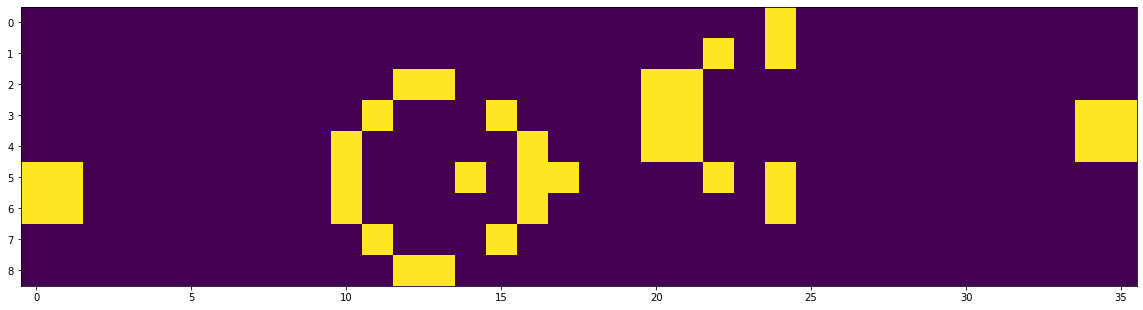

In [89]:
    
pat = load_lif("lifep/gun30.LIF")
show_gray(expand(next_gen(next_gen(centre(centre(pat))))))
   

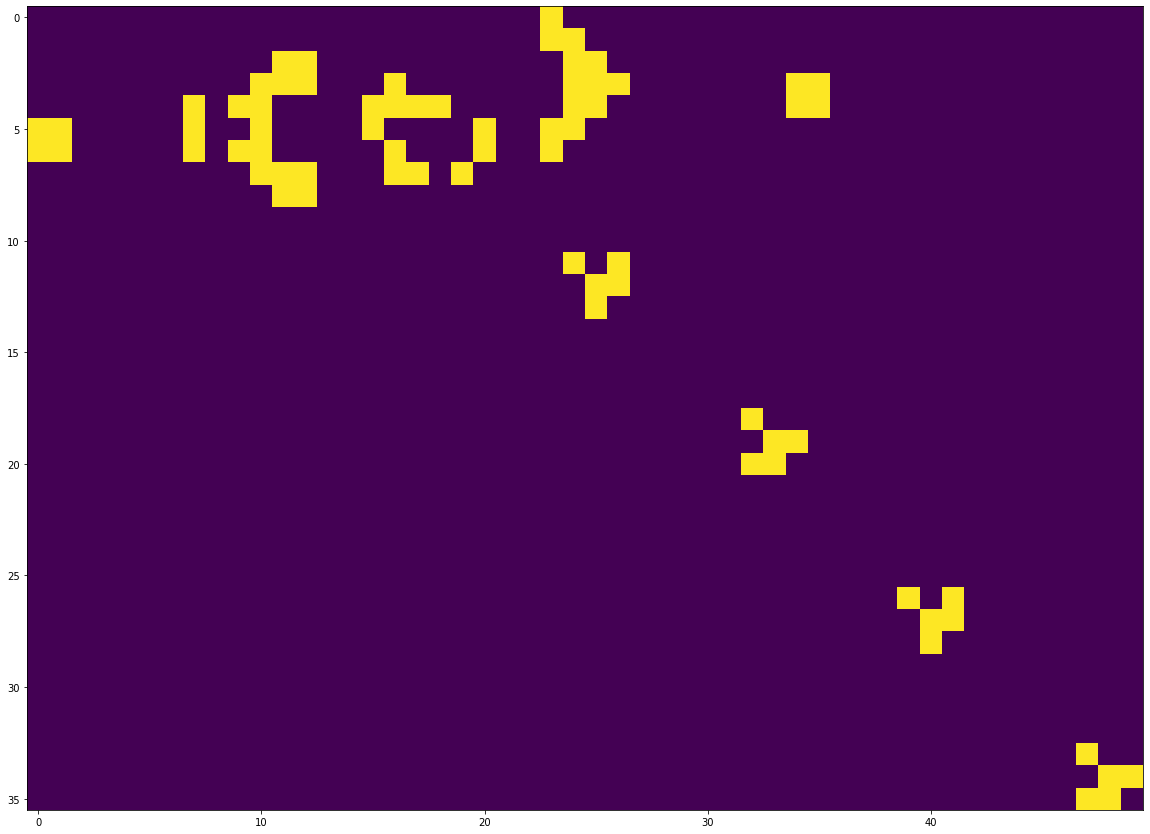

In [90]:
show_gray(expand(successor(centre(centre(centre(pat))))))

Guessed RLE


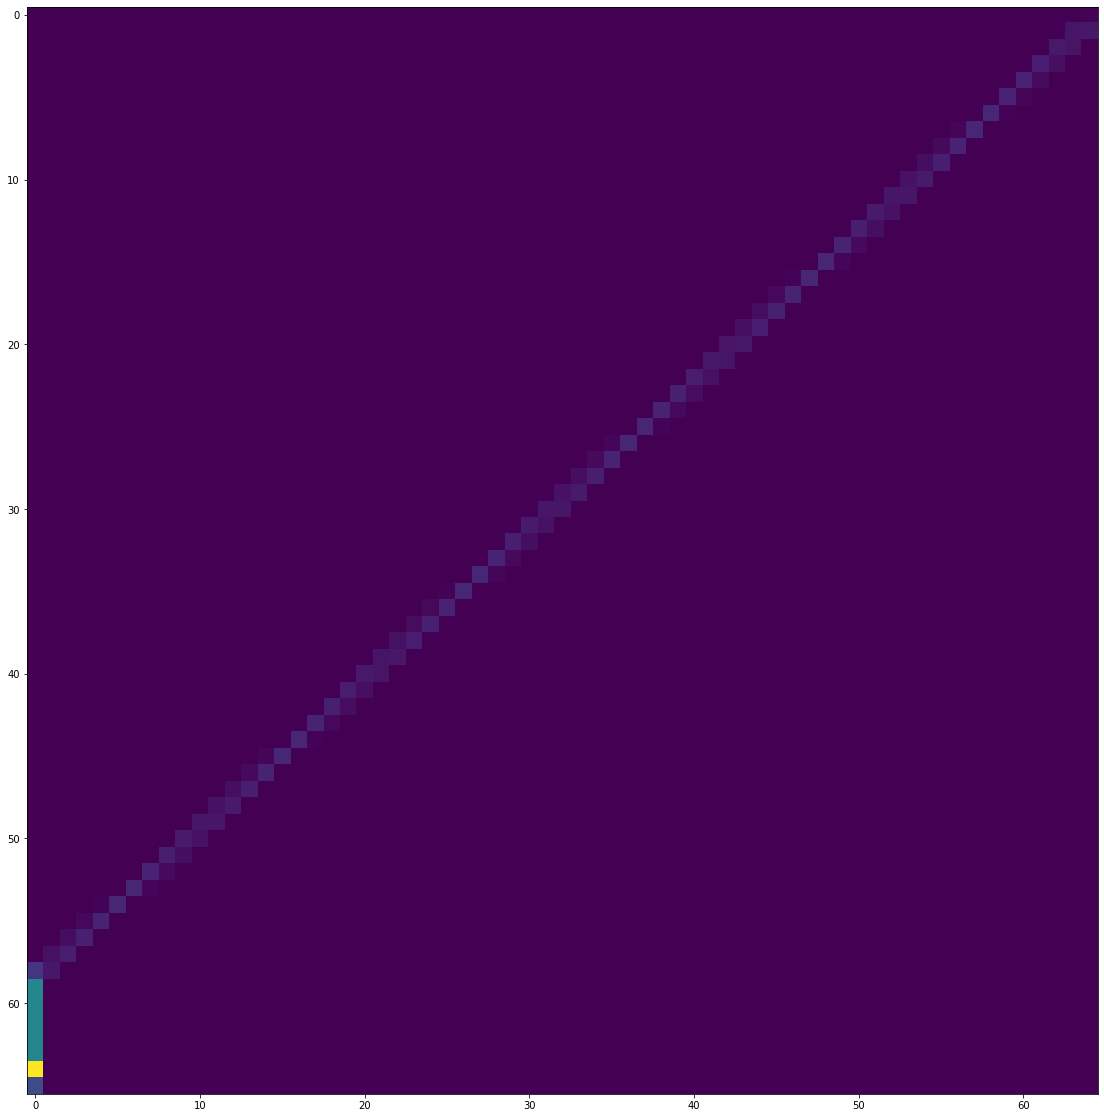

In [91]:
pat = load_lif("pat/slide-o-03f-120.lif")
show_gray(expand(ffwd(pat, 9), level=11))

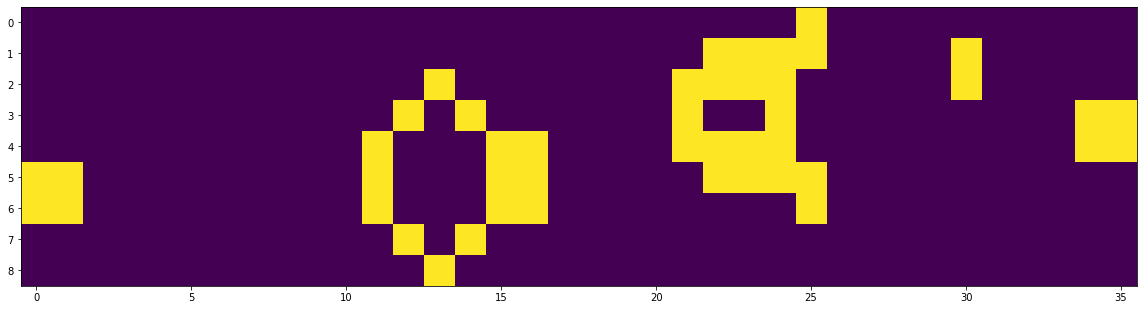

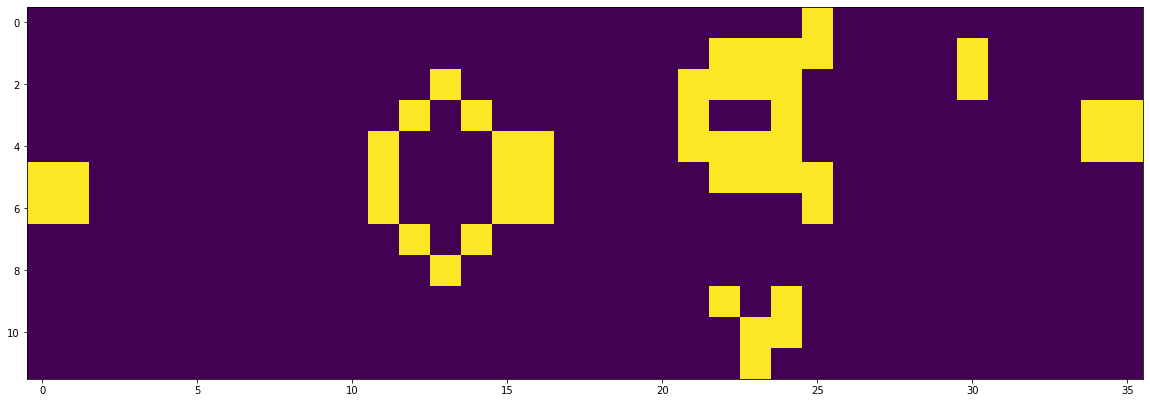

In [35]:
pat = load_lif("lifep/gun30.lif")
show_gray(expand(pat))
show_gray(expand(advance(centre(centre(pat)), 30)))

In [20]:
variable_step.cache_info()

CacheInfo(hits=0, misses=0, maxsize=16777216, currsize=0)

In [22]:
join.cache_info()

CacheInfo(hits=561324, misses=52246, maxsize=16777216, currsize=52246)

In [21]:
successor.cache_info()

CacheInfo(hits=504184, misses=52222, maxsize=16777216, currsize=52222)

In [495]:
from itertools import product

# pre-generate all 4x4 successors
def product_tree(pieces):
    return [join(a, b, c, d) for a, b, c, d in product(pieces, repeat=4)]

boot_2x2 = product_tree([on, off])
boot_4x4 = product_tree(boot_2x2)
centres = [variable_step(p, 1) for p in boot_4x4]

In [244]:
successor.cache_info()

CacheInfo(hits=131072, misses=65536, maxsize=16777216, currsize=65536)